---
title: "So you know convolutions huh?"
author: Deepam Minda
date: "July 30, 2024"
categories: [cnns, deep-learning]
format:
  html:
    toc: true
    toc-depth: 3
    html-math-method: katex
    # css: ../../styles.css
    code-fold: true
execute:
  warning: false
---

Welcome to the land of vision in deep learning. Gone are the days you need to look at 10 types of thresholding and 20 types of data pre-processing and apply a logistic classifier on the outputs of a cnn feature extractor. These days you can just load a pretrained model and watch a decaying training and validation loss and feel good about yourself.

Turns out, this doesnt last long though. You eventually get around to understand what these models actually are because you need to! 
And when it comes to vision, you surely cannot leave out CNNs. Sure its all transformers nowadays but CNNs or convolutional neural networks were essentially the first deep learning models to make a significant impact in the field of computer vision and most would agree started the whole deep learning wave in the modern era. AlexNet, VGG, resnets would be considered the pioneer models in this field.

Now you might ask: All this sounds interesting Deepam, but what the hell is a convolution? 


## Convolutions

Convolutions is just an operation between 2 signals (vectors/matrices/continuous-signals) that returns a 3rd signal. It represents how one signal modifies the other signal. In general terms, convolution is used to apply a filter to a signal or data.

## Steps in Convolution

1. **Flip the Kernel**: The kernel (or filter) $(g)$ is flipped both horizontally and vertically. 
why?-> [link](https://dsp.stackexchange.com/questions/5992/flipping-the-impulse-response-in-convolution/6355#6355)
2. **Slide the Kernel**: The flipped kernel is then slid (convolved) over the input function $(f)$ .
3. **Element-wise Multiplication**: At each position, element-wise multiplications are performed between the kernel and the overlapping portion of the input function.
4. **Summation**: The results of these multiplications are summed to get a single value, which is placed in the output function.

For a 1d array this might look like this: 

In [1]:
import numpy as np 

f = np.array([1,2,3,-1, 10, -4])
g = np.array([1,0,-1])

print(f"f: {f}")
print(f"g: {g}")
window_size = g.shape[0]
result = []
print("\nslice_of_f * g[::-1]: ")
for idx, i in enumerate(range(len(f)-window_size+1)):
    slice_of_f = f[i:i+window_size]
    print(f"{idx}. sum({slice_of_f} * {g[::-1]}) = sum({slice_of_f * g[::-1]}) = {np.sum(slice_of_f * g[::-1])}")
    result.append(np.sum(slice_of_f * g[::-1]))

print(f"\nresult python: {result}")
print(f"result using np.convolve: {np.convolve(f,g, mode='valid')}") # valid is the no padding

f: [ 1  2  3 -1 10 -4]
g: [ 1  0 -1]

slice_of_f * g[::-1]: 
0. sum([1 2 3] * [-1  0  1]) = sum([-1  0  3]) = 2
1. sum([ 2  3 -1] * [-1  0  1]) = sum([-2  0 -1]) = -3
2. sum([ 3 -1 10] * [-1  0  1]) = sum([-3  0 10]) = 7
3. sum([-1 10 -4] * [-1  0  1]) = sum([ 1  0 -4]) = -3

result python: [2, -3, 7, -3]
result using np.convolve: [ 2 -3  7 -3]


That wasnt so hard was it? The concept seems simple enough. slide one signal over another and each time, do element wise multiplication and sum to get a value. 

Lets look at an example for 2d arrays. Here lets take 2 arrays of shapes (6,6) and (3,3). First we need to flip the 2nd array both horizontally and vertically. Then, as the (3,3) array slides over the other we should get a (4,4) matrix. Lets see how this works.

In [2]:
from scipy.signal import convolve2d

f = np.random.rand(6,6)
g = np.array([[1,0,-1],[1,0,-1],[1,0,-1]])

print(f"f shape: {f.shape}")
print(f"g shape: {g.shape}")
# print(f"result: {np.convolve(f,g, mode='valid')}")

f shape: (6, 6)
g shape: (3, 3)


In [3]:
f_rows, f_columns = f.shape 
g_rows, g_columns = g.shape

result = np.zeros((f_rows-g_rows+1, f_columns-g_columns+1))
for i in range(f_rows-g_rows+1):
    for j in range(f_columns-g_columns+1):
        item = f[i:i+g_rows, j:j+g_columns] * g[::-1, ::-1]
        if i<3 and j==0:
            print(f"result[{i},{j}] \n->sum(f[{i}:{i+g_rows}, {j}:{j+g_columns}] * g[::-1, ::-1]): \n{item}")
            print(f"-> {np.sum(item)}\n")
        result[i,j] = np.sum(item)
print("... and so on.\n")
print(f"final result: \n{result}\n")
# print(f"result shape: {result.shape}")

result = convolve2d(f,g, mode='valid')
print(f"Which is the same as the result of scipy.convolve2d: \n{result}")

result[0,0] 
->sum(f[0:3, 0:3] * g[::-1, ::-1]): 
[[-0.50043879  0.          0.96533241]
 [-0.57575706  0.          0.96608904]
 [-0.26910721  0.          0.02162452]]
-> 0.6077429029172687

result[1,0] 
->sum(f[1:4, 0:3] * g[::-1, ::-1]): 
[[-0.57575706  0.          0.96608904]
 [-0.26910721  0.          0.02162452]
 [-0.16668093  0.          0.3390268 ]]
-> 0.3151951622196356

result[2,0] 
->sum(f[2:5, 0:3] * g[::-1, ::-1]): 
[[-0.26910721  0.          0.02162452]
 [-0.16668093  0.          0.3390268 ]
 [-0.61184461  0.          0.5508951 ]]
-> -0.1360863354721753

... and so on.

final result: 
[[ 0.6077429  -0.14661592  0.29036408  0.19567047]
 [ 0.31519516 -0.07866619  0.52920251 -0.44948681]
 [-0.13608634 -0.90171287  0.94176527 -0.91012219]
 [ 0.69872346 -0.43798077 -0.38699654 -0.62373429]]

Which is the same as the result of scipy.convolve2d: 
[[ 0.6077429  -0.14661592  0.29036408  0.19567047]
 [ 0.31519516 -0.07866619  0.52920251 -0.44948681]
 [-0.13608634 -0.90171287  0.9417

## Convolutional neural networks (CNNs/Convnets)
With that out of the way lets back up for a second and remember our old friends feed forward networks. What is the problem with using feed forward networks to process images?
As it turns out, quite a few things:

1. Feed forward networks do not share information between different data points in the network. For example if X = [0,1,2,3] is a vector of input to the network, all the interactions between weights happen independently for each data point in one sample of data.
This works fine for tabular features of some data, because they actually are not dependent on their spatial postion wrt each other. The model will learn the same if you shuffle all columns of a dataset. <br><br>But images pixels are a different type of data. They are inherently very locally dependent. If you look at a single pixel, it is very likely to be highly correlated with its neighboring pixels. Hence our network should process atleast patches of images at a time. 


2. Earlier when classical image processing methods were being used, many a times hand-made "filters" were used to extract features from images. In CNNs, we learn these filters! and we learn a lot of them. So think of each layer in this CNN as having a lot of these filters which are learned during network.

3. Another concept that helps is parameter sharing. We could in thoery have different set of filters for different patches in the image, but this would shoot up the parameter count of our model. So in a single layer, we use a single set of filters for all patches in the image.


Lets get into the tensor shapes now. 

## Shapes

Images are mostly represented as 3d tensors, of shape: $(H_{in}, W_{in}, C_{in})$
where $H_{in}$ is the height of the image, $W_{in}$ is the width of the image and $C_{in}$ is the number of channels in the image. It helps to visualize volumes (3d) of numbers interacting with each other and resulting in volumes of data.

- input to Conv layer -> $(H_{in}, W_{in}, C_{in})$ 
- filters/weights of Conv layer -> $C_{out} * (k,k,C_{in})$  (ignoring biases for simplicity)
- output of Conv layer -> $(H_{out}, W_{out}, C_{out})$


$C_{out}$ number of filters are learned. Each one is a tensor of shapes $(k,k,C_{in})$ where $k$ is the size of the filter (assuming square for simplicity too) and $C_{in}$ is the number of input channels. $C_{out}$ is the number of filters learned. 

So when $C_{out}$ filters of shape $(k,k,C_{in})$ are applied to an image of shape $(H_{in},W_{in},C_{in})$, the output is a 3d tensor of shape $(H_{out}, W_{out}, C_{out})$ where $H_{out}$ is the height of the output and $W_{out}$ is the width of the output.


That is basically the essence of a convolutional layer. There are a few other parameters to consider which together decide the values for $H_{out}$ and $W_{out}$.

1. $S$: The stride. When we slide the filter over the input, we move it $S$ steps at a time. If stride is 2, we move the filter 2 pixels at a time. The output shape will be inversely proportional to the stride size.
2. $P$: The padding. if we want to keep the height and width of the image, we can pad the input with zeros. see example here:

```python
f: [1,  2,  3, -1, 10, -4]
g: [1, 0, -1]
convolve(f,g) = [2,-3,7,-3]
```
But after padding $f$ with 2 zeros on either side:

```python
f: [0, 0, 1,  2,  3, -1, 10, -4, 0, 0]
convolve(f,g) = [1, 2, 2, -3, 7, -3, -10, 4]
```

I would at this point ask you to take me on my word when i say that the output dimensions turn out to be: 

- $H_{out}=(H_{in}−k+2P)/S+1$
- $W_{out}=(W_{in}−k+2P)/S+1$

Altough this is not true everytime, it is useful as a rule of thumb. the only times this wont be true are if we have different $S$, $k$ or $P$ along the height and width dimensions. 

To visualize the interaction of filters and input images, you can go [here](https://ezyang.github.io/convolution-visualizer/).

## Other layers

CNN layers are usually follwed by activation functions like ReLU and then a pooling layer. 

Pooling layer? yeah, pooling layer. So given a volume of input say instead of using filters we just use operations non parameterized like min and max just to downsample the data and get a smaller volume. That is what pooling does. But why would we do something like that? 2 reasons:

1. Reduce the number of parameters: By reducing the number of parameters, the model can learn more general features.
2. Reduce the amount of overfitting: By reducing the amount of overfitting, the model can learn more robust features.

## Some jargon

- filters: also called kernels. they are learnable parameters in a convolutional layer. Each filter is a small matrix (usually 3x3 or 5x5) that slides over the input image to detect specific features. The values in these filters are updated during training to learn important features for the task at hand.
- activation maps: the output when a \[Conv->Relu\] filter interacts with entire image.
- feature maps: the output of a convolutional layer. (before the activation)
- depth: refers to the number of channels.
- receptive field: the area of the input that a given filter is able to see at a time is called the receptive field.


## A Simple CNN architecture

Lets assume a simple task of image classification. The most common form of a CNN architecture stacks a few CONV-RELU layers, follows them with POOL layers, and repeats this pattern until the image volume has reduced to a small size. At some point, it is common to transition to fully-connected layers. The last fully-connected layer holds the output, such as the class scores. In other words, the most common ConvNet architectures follow the pattern:

`INPUT -> [[CONV -> RELU]*N -> POOL?]*M -> [FC -> RELU]*K -> FC`

here FC: feed-forward layer. 

Note that since architectures like [Resnet](https://arxiv.org/pdf/1512.03385) and [Inception](https://arxiv.org/pdf/1409.4842) emerged, this is not the case, and the CNNs feature more intricate and different connectivity structures.

## CNN characteristics

While we are here, let us also take note of some characteristics of CNNs:

* **Sparse connectivity**: CNNs focus on local patterns in data, particularly useful for spatial data like images. A single patch in feature map is connected to only a small patch of image (in MLPs there is dense/full connection).
* **Parameter sharing**: the same kernel/filter slides across the image. ie different neurons in each activation map is calculated using the same filter. In MLPs each neuron in the output space is calculated using different weight values.  this makes it efficient for computation.
* **Spatial hierarchy**: CNNs build a hierarchy of increasingly abstract features. Lower layers detect simple features (e.g., edges), while deeper layers combine these to detect more complex patterns.
* **Translation invariance**: CNNs can recognize patterns regardless of their position in the input. This is because we are using filters that slide over patches of data, so information is processed in the same way for different patches of data This is crucial for tasks like object recognition in images.


![visualizing activation maps in cnns. From the paper 'Visualizing and Understanding Convolutional Networks'](visualizing-activation-maps-cnns.png){#fig-cnn-activation-maps height=90%, width=90%}

Have a look at [this](https://arxiv.org/pdf/1311.2901) wonderful paper that dives deep into visualizing and understanding Cnns.

## Lets train a model yaar

I'd be remiss if I let you finish here thinking that you got CNNs down. Just for old times sake, lets train a model to classify images from the fashion mnist dataset. The dataset contains very small grayscale (ie single channel) images of size (28*28). 

> the below code is all generated by claude-sonnet-3.5, bcuz its kinda boring to train a toy model on a toy dataset, that too for classification. dont worry though, ill soon be back with a more interesting vision problem to get our hands dirty.

device: mps
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 28, 28]             320
         MaxPool2d-2           [-1, 32, 14, 14]               0
            Conv2d-3           [-1, 64, 14, 14]          18,496
         MaxPool2d-4             [-1, 64, 7, 7]               0
            Conv2d-5             [-1, 32, 7, 7]          18,464
         MaxPool2d-6             [-1, 32, 3, 3]               0
            Linear-7                  [-1, 128]          36,992
            Linear-8                   [-1, 10]           1,290
Total params: 75,562
Trainable params: 75,562
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.37
Params size (MB): 0.29
Estimated Total Size (MB): 0.67
----------------------------------------------------------------
Epoch [1/5], Loss: 0.5107
Epoch 

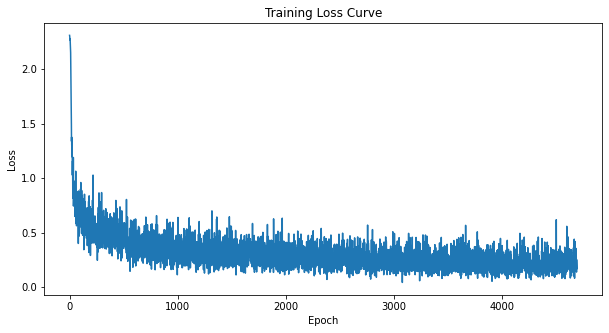

Test Accuracy: 90.38%


In [22]:
#| code-fold: false
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from torchsummary import summary
import numpy as np

# Define the CNN architecture
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)     # input channels in layer1 is equal to number of input channels in the input image
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv3 = nn.Conv2d(64, 32, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(32 * 3 * 3, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(torch.relu(self.conv2(x)))
        x = self.pool(torch.relu(self.conv3(x)))
        x = x.view(-1, 32 * 3 * 3)     # flattening the tensor to feed it to FC layer
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_built() else "cpu")
print(f"device: {device}")

# Load and preprocess the Fashion MNIST dataset (just plain old standardization)
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])

train_dataset = torchvision.datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = torchvision.datasets.FashionMNIST(root='./data', train=False, download=True, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# Initialize the model, loss function, and optimizer
model = SimpleCNN()

# Visualize model summary
summary(model, (1, 28, 28), device="cpu")

model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
num_epochs = 5
all_losses = []
for epoch in range(num_epochs):
    model.train()
    epoch_losses = []
    for batch_idx, (data, targets) in enumerate(train_loader):
        data, targets = data.to(device), targets.to(device)
        
        optimizer.zero_grad()
        outputs = model(data)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        epoch_losses.append(loss.item())
    
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {np.mean(epoch_losses):.4f}")
    all_losses.extend(epoch_losses)

# plot train loss curve
plt.figure(figsize=(10, 5))
plt.plot(all_losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Curve')
plt.show()

# Evaluation
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for data, targets in test_loader:
        data, targets = data.to(device), targets.to(device)
        outputs = model(data)
        _, predicted = torch.max(outputs.data, 1)
        total += targets.size(0)
        correct += (predicted == targets).sum().item()

print(f'Test Accuracy: {100 * correct / total:.2f}%')

Neat!! 
Now let's visualize some of the predictions.

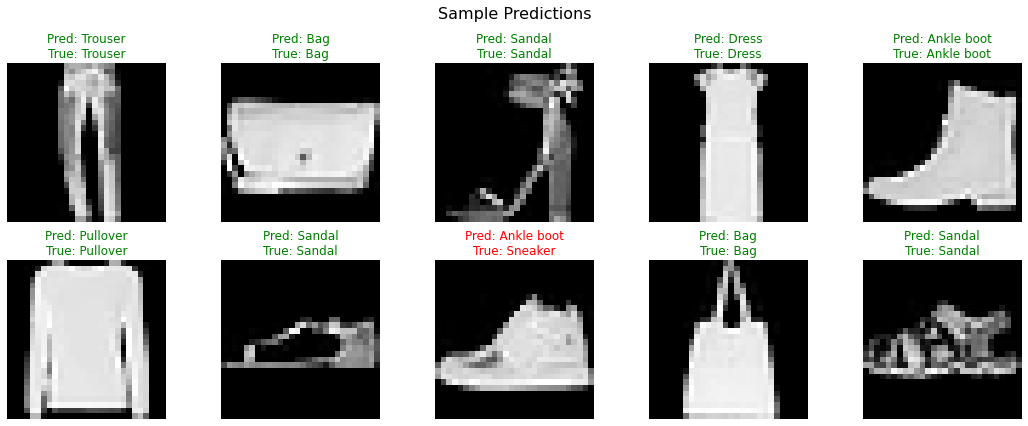

In [16]:
#| code-fold: false

import random

class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']   # verify using train_dataset.classes

model.eval()
fig, axes = plt.subplots(2, 5, figsize=(15, 6))
fig.suptitle('Sample Predictions', fontsize=16)

with torch.no_grad():
    for i, idx in enumerate(random.sample(range(len(test_dataset)), 10)):
        image, label = test_dataset[idx]
        output = model(image.unsqueeze(0).to(device))
        predicted = output.argmax(1).item()
        
        ax = axes[i // 5, i % 5]
        ax.imshow(image.squeeze(), cmap='gray')
        ax.axis('off')
        ax.set_title(f'Pred: {class_names[predicted]}\nTrue: {class_names[label]}', 
                     color='green' if predicted == label else 'red')

plt.tight_layout()
plt.show()

---

I hope you clearly understand the core CNN fundamental architecture. This is just the base that'll act as a foundation for more interesting architectures as we go on. Until then, see you in the next one!

Byeee :)

## References

- sebastian raschka course material [here](https://sebastianraschka.com/blog/2021/dl-course.html#l13-introduction-to-convolutional-neural-networks)
- CS231N Cnn notes [here](https://cs231n.github.io/convolutional-networks/#case). Great intuition and more detail about the shapes, local connectivity, spatial arrangement, and loads of other stuff.
- arc folder where i maintain things related to CNNs [here](https://arc.net/folder/08A8A6B3-0E12-4F25-A3B2-B3B956068848)
- beginner friendly article on Medium (its a great blog-series for ML) [here](https://medium.com/@ageitgey/machine-learning-is-fun-part-3-deep-learning-and-convolutional-neural-networks-f40359318721)
- Visualizing and Understanding Convolutional Networks. 2014 paper [here](https://arxiv.org/pdf/1311.2901)
